<a href="https://colab.research.google.com/github/coldfir3/KAGGLE-SETI/blob/main/Seti%20V2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial Setup

In [1]:
import sys
import os
is_colab = 'google.colab' in sys.modules
!nvidia-smi

Sun Aug 15 17:35:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Installing packages

In [2]:
if is_colab:
    !pip install -Uqqq wandb
    !pip install -Uqqq fastai
    !pip install -Uqqq timm

     |████████████████████████████████| 1.6 MB 12.9 MB/s 
     |████████████████████████████████| 97 kB 7.9 MB/s 
     |████████████████████████████████| 133 kB 51.7 MB/s 
     |████████████████████████████████| 170 kB 55.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 188 kB 12.9 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 376 kB 14.2 MB/s 


### Loading packages

In [ ]:
from fastai.vision.all import *
import wandb
from fastai.callback.wandb import *
from argparse import Namespace
import timm

### Downloading data



In [7]:
wandb.Api()
if is_colab:

    from google.colab import drive
    from os.path import exists

    if not exists('/content/drive'):
        drive.mount('/content/drive')
    %run '/content/drive/MyDrive/Kaggle/My Kaggle [colab].ipynb'

    if not exists('/content/train/'):
        setup_kaggle()
        get_kaggle_data('d', 'coldfir3/seti-spatial-dataset-v3')
        ! kaggle competitions download -c seti-breakthrough-listen -f train_labels.csv

Mounted at /content/drive
Downloading...
From: https://drive.google.com/uc?id=19H3_BYiHuzIiY9vo9rBsVIu1aSlPlbKx
To: /content/Kaggle/kaggle.json
100% 64.0/64.0 [00:00<00:00, 114kB/s]
drive  Kaggle  sample_data
     |████████████████████████████████| 58 kB 5.7 MB/s 
! kaggle datasets download -d coldfir3/seti-spatial-dataset-v3
100% 15.8G/15.8G [03:38<00:00, 73.3MB/s]
100% 15.8G/15.8G [03:38<00:00, 77.4MB/s]
seti-spatial-dataset-v3.zip


Extracting:   0%|          | 0/99996 [00:00<?, ?it/s]

  0% 0.00/522k [00:00<?, ?B/s]
100% 522k/522k [00:00<00:00, 60.8MB/s]


## Setting up the DataFrames

In [9]:
from sklearn.model_selection import StratifiedKFold
if is_colab: 
    base_path = '/content/train/'
    train_df = pd.read_csv('/content/train_labels.csv.zip')
else:
    pass
    # train_study = pd.read_csv('/media/passos/Data/DSET/siim-covid19-detection/train_study_level.csv')

train_df['fold'] = -1
train_df['path'] = train_df['id'].apply(lambda x: base_path + x + '.png')
train_df['label'] = train_df['target'].apply(lambda x: 'alien' if x == 1 else 'no-alien')
skf = StratifiedKFold(n_splits = 6, random_state = 42, shuffle = True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df['id'], train_df['target'])):
    train_df.loc[test_index, 'fold'] = fold
train_df

,id,target,fold,path,label
0,0000799a2b2c42d,0,3,/content/train/0000799a2b2c42d.png,no-alien
1,00042890562ff68,0,3,/content/train/00042890562ff68.png,no-alien
2,0005364cdcb8e5b,0,4,/content/train/0005364cdcb8e5b.png,no-alien
3,0007a5a46901c56,0,3,/content/train/0007a5a46901c56.png,no-alien
4,0009283e145448e,0,3,/content/train/0009283e145448e.png,no-alien
...,...,...,...,...,...
59995,fff8217fe05aba3,0,4,/content/train/fff8217fe05aba3.png,no-alien
59996,fffa939e610ed70,0,4,/content/train/fffa939e610ed70.png,no-alien
59997,fffbb1c9c3d6c31,1,5,/content/train/fffbb1c9c3d6c31.png,alien
59998,fffc9a763d23647,0,0,/content/train/fffc9a763d23647.png,no-alien


## DataBlock & DataLoader

In [10]:
import albumentations as A
class AlbumentationsTransform(Transform):
    split_idx = 0
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
tfms = A.Compose([
        A.HorizontalFlip(p=.5),
        A.VerticalFlip(p=.5),
        A.ShiftScaleRotate(rotate_limit=0, p=.25),
        A.MotionBlur(p=.2),
        A.IAASharpen(p=.25)
])

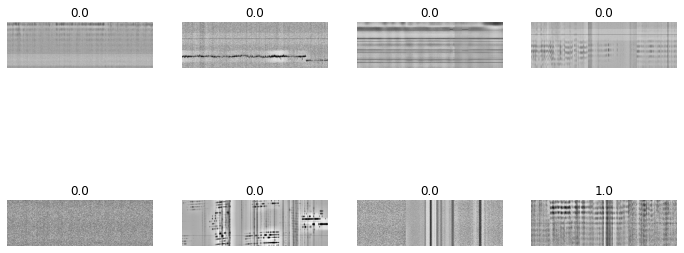

In [19]:
def get_dls(df, **config):
    is_colab = 'google.colab' in sys.modules
    workers = 2 if is_colab else 10
    splitter = IndexSplitter(df[df.fold == config['fold']].index)
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), RegressionBlock()),
        splitter = splitter,
        getters=[ColReader('path'), ColReader('target')],
        item_tfms=AlbumentationsTransform(tfms),
        batch_tfms=[Flip(), Normalize(mean = tensor(0.5), std = tensor(0.177))]
        ).dataloaders(df, bs = config['bs'], num_workers = workers)

dls = get_dls(train_df, **{'bs':8, 'fold':0})
dls.show_batch()

In [12]:
# https://arxiv.org/pdf/2103.09950.pdf
# https://github.com/yundaehyuck/Learning-to-resize-images-for-computer-vision-tasks/blob/main/resizing_network.ipynb

class ResBlock(nn.Module):
    def __init__(self,num_channels=16):
        super(ResBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(num_channels,num_channels,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        
        self.conv2 = nn.Conv2d(num_channels,num_channels,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self,x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        
        out = self.leakyrelu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        
        return out

def make_block(r,n):
    residual = []
    
    for i in range(r):
        block = ResBlock(num_channels=n)
        residual.append(block)
    
    return nn.Sequential(*residual)

class ResizingNetwork(nn.Module):
    def __init__(self, img_size, in_chans = 3, r=1, n=16):
        super(ResizingNetwork, self).__init__()

        self.img_size = img_size
        
        self.conv1 = nn.Conv2d(in_channels=in_chans,out_channels=n,kernel_size=7,stride=1,padding=3)
        self.leakyrelu1 = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        
        self.conv2 = nn.Conv2d(n,n,kernel_size=1,stride=1)
        self.leakyrelu2 = nn.LeakyReLU(negative_slope=0.2,inplace=True)
        self.bn1 = nn.BatchNorm2d(n)
                
        self.resblock = make_block(r,n)        
        
        self.conv3 = nn.Conv2d(n,n,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(n)
        
        self.conv4 = nn.Conv2d(n,out_channels=in_chans,kernel_size=7,stride=1,padding=3)
        
    def forward(self, x):
        
        residual = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        
        out = self.conv1(x)
        out = self.leakyrelu1(out)
        
        out = self.conv2(out)
        out = self.leakyrelu2(out)
        out = self.bn1(out)
        
        out_residual = F.interpolate(out, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        
        out = self.resblock(out_residual)
        
        out = self.conv3(out)
        out = self.bn2(out)
        out += out_residual
        
        out = self.conv4(out)
        out += residual
        
        return out

In [13]:
def create_timm_model(**cfg):
    model_name = cfg.pop('arch')
    if 'img_size' in cfg.keys():
        img_size = cfg.pop('img_size')
        res = ResizingNetwork(img_size, cfg['in_chans'])
    else:
        img_size = 224
        res = Identity()
    body = timm.create_model(model_name, True, **cfg)
    body = nn.Sequential(res, body)

    ## head
    nf = body(torch.randn((2,cfg['num_classes'],img_size,img_size))).shape[-1]
    head = nn.Linear(nf, cfg['num_classes'])

    model = nn.Sequential(body, head)

    return model

# model = create_timm_model(**{
#     'arch':'swin_large_patch4_window7_224',
#     'img_size':224,
#     'in_chans' : 1, 
#     'num_classes' : 1,
# })
# m

In [14]:
class SaveAndLogBestModel(SaveModelCallback):

    def __init__(self, mon='valid_loss', **kwargs):
        super().__init__(monitor = mon, fname = mon, **kwargs)

    def _save(self, name): 
        self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)
        self.model_path = Path(*list(self.last_saved_path.parts[:-1])) / (self.fname + '.pth')
        self.metadata = {n:s for n,s in zip(self.recorder.metric_names, self.recorder.log) if n not in ['time']}

    def after_fit(self, **kwargs):
        metadata = self.metadata
        for k,v in metadata.items(): metadata[k] = str(v)
        name = f'run_{wandb.run.id}_model'
        artifact_model = wandb.Artifact(name=name, type='model', metadata=metadata, description='trained model')
        with artifact_model.new_file(name, mode='wb') as fa:
            fa.write(self.model_path.read_bytes())
        wandb.run.log_artifact(artifact_model, aliases = [f'best {self.fname}', f'epoch {metadata["epoch"]}'])

In [15]:
class wandb_learner():

    def __init__(self, df, **config):

        cbs = []
        if config['Fit']['n_epoch'] < 1:
            df = df.sample(frac=config['Fit']['n_epoch']).reset_index(drop=True)
            config['Fit']['n_epoch'] = 1
            
        self.df = df
        self.config = config

        self.dls = get_dls(df, **config['Dataloader'])
        self.model = create_timm_model(**config['Model'])
        self.learn = Learner(self.dls, self.model, **config['Learner']).add_cbs(cbs)

        self.scheduler = self.config['Fit'].pop('scheduler')
        self.wandb_config = self.config.pop('WandB')

    def unfrozen_count(self):
        return sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, self.model.parameters())])

    def fit(self):

        if self.scheduler == 'fine_tune':

            lr_max  = self.config['Fit'].pop('lr_max')
            n_epoch = self.config['Fit'].pop('n_epoch')
            freeze_lr = self.config['Fit'].pop('freeze_lr')
            freeze_epochs = self.config['Fit'].pop('freeze_epochs')
            lr_mult = self.config['Fit'].pop('lr_mult')
            lr = slice(lr_max/lr_mult, lr_max)

            self.learn.freeze()
            print(f'Training {self.unfrozen_count()} parameters ...')
            self.learn.fit_one_cycle(freeze_epochs, slice(freeze_lr), pct_start=0.99, **self.config['Fit'])

            self.learn.unfreeze()
            print(f'Training {self.unfrozen_count()} parameters ...')
            self.learn.fit_one_cycle(n_epoch - freeze_epochs, lr, pct_start=0.3, div=5.0, **self.config['Fit'])    
            
            self.config['Fit']['lr_max'] = lr_max
            self.config['Fit']['n_epoch'] = n_epoch
            self.config['Fit']['freeze_lr'] = freeze_lr
            self.config['Fit']['freeze_epochs'] = freeze_epochs
            self.config['Fit']['lr_mult'] = lr_mult
            
        elif self.scheduler == 'one_cycle': 
          print(f'Training {self.unfrozen_count()} parameters ...')
          self.learn.fit_one_cycle(**self.config['Fit'])

        elif self.scheduler == 'cossine': print('not implemented')

        elif self.scheduler == 'reduce_on_plateau': print('not implemented')

        else: self.learn.fit(**self.config['Fit'])

    def wandb_fit(self):
        
        with wandb.init(config = self.config, **self.wandb_config) as run:
            self.learn.add_cb(WandbCallback(log=None, log_preds=False, log_model=False))
            self.learn.add_cb(SaveAndLogBestModel())
            self.fit()

In [ ]:
CFG = {
    'WandB' : {
        'project' : 'Seti V1',
        'tags': ['transformer', 'BASELINE', 'RESIZE'],
        'notes':
        """
        """,
    },
    'Dataloader' : {
        'bs' : 8,
        'fold' : 0, 
    },
    'Model' : {
        'arch':'swin_large_patch4_window7_224',
        'img_size':224,
        'in_chans' : 1, 
        'num_classes' : 1,
    },
    'Learner' : {
        'loss_func' : BCEWithLogitsLossFlat(),
        'metrics' : RocAucMulti(),
        'cbs' : [
                #  GradientAccumulation(8192//8),
                 MixUp()
                ],
        'splitter' : default_split
      },
    'Fit' : {
        'scheduler' : 'fine_tune',
        'lr_max' : 0.001,
        'n_epoch' : 20,
        'freeze_lr' : 0.002,
        'freeze_epochs' : 2,
        'lr_mult' : 100,
    }
}

learn = wandb_learner(train_df, **CFG)
# learn.learn.lr_find()
learn.wandb_fit()
# learn.fit()

Training 86530 parameters ...


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.323542,0.324741,0.532037,19:30


Better model found at epoch 0 with valid_loss value: 0.3247407078742981.
